# 1.  Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel, SelectPercentile, chi2
from sklearn.metrics import recall_score, roc_curve, roc_auc_score, classification_report, confusion_matrix

# 2. Defaults

In [2]:
seed = 12 # 12 ears
y = 'OverallPoF' # target
dataset_dir = '00 - Dataset/03 - Sampling Splits/'

# feature selection threshold
l1_threshold = 0.05
l2_threshold = '1.5 * mean'

# library options
plt.rcParams[ 'figure.figsize' ] = (16, 9) # larger plots
plt.rcParams[ 'font.size' ] = '16' # larger fonts
pd.set_option('display.max_colwidth', None) # print evth in pd df

params = { }

# cv parameters
params[ 'cv' ] = {
    'cv': 10, # k-fold
    'n_jobs': -1, # use all cpu cores
    'scoring': 'recall_macro',
    'return_train_score': True
}

# classifier parameters
params[ 'base' ] = {
    'dual': False,
    'random_state': seed,
    'max_iter': 23220451 * 12,
    'class_weight': 'balanced'
}
params[ 'hyper' ] = {
    'penalty': [ 'l1', 'l2' ],
    'C': [ 0.01, 0.1, 1, 10, 100 ]
}

# 3. Datasets

In [3]:
datasets = { }
for sample in next(os.walk(dataset_dir))[ 1 ]:
    sample_name = sample.split(' - ')[ 1 ]
    sample_dir = dataset_dir + sample + '/'
    
    # X
    X_train = pd.read_csv(sample_dir + 'X_train.csv')
    X_val = pd.read_csv(sample_dir + 'X_val.csv')
    X_test = pd.read_csv(sample_dir + 'X_test.csv')
    
    # y
    y_train = pd.read_csv(sample_dir + 'y_train.csv')[ y ]
    y_val = pd.read_csv(sample_dir + 'y_val.csv')[ y ]
    y_test = pd.read_csv(sample_dir + 'y_test.csv')[ y ]
    
    # absorbance only
    X_train = X_train.filter(regex = r'fa[0-9]*')
    X_val = X_val.filter(regex = r'fa[0-9]*')
    X_test = X_test.filter(regex = r'fa[0-9]*')
    
    datasets[ sample_name ] = {
        'X_train': X_train,
        'y_train': y_train,
        'X_val': X_val,
        'y_val': y_val,
        'X_test': X_test,
        'y_test': y_test,
    }

# 4. Functions

In [27]:
def ttest_refit(cv_results):
    splits = set([ 
        k.split('_')[ 0 ] for k in cv_results.keys() if k.startswith('split') 
    ])
    n_folds = len(cv_results[ 'params' ])
    
    # ttest significance whether train/test means differ
    significance = [ ]
    for i in range(n_folds):
        train_scores = [ ]
        test_scores = [ ]
        
        for split in splits:
            train_score = cv_results[ split + '_train_score' ][ i ]
            test_score = cv_results[ split + '_test_score' ][ i ]
            
            train_scores.append(train_score)
            test_scores.append(test_score)
        
        _, pvalue = stats.ttest_ind(
            train_scores, 
            test_scores,
            equal_var = False
        )
        
        if (pvalue > 0.05):
            significance.append(False)
        else:
            significance.append(True)
    
    # use cv's ranking as default index
    chosen_idx = list(cv_results[ 'rank_test_score' ]).index(1)
    
    # select index backwards
    for i in range(n_folds - 1, -1, -1):
        if (significance[ i ]):
            continue
        chosen_idx = i
        break
        
    return chosen_idx

def custom_refit(cv_results):
    train_scores = cv_results[ 'mean_train_score' ]
    train_sd = cv_results[ 'std_train_score' ]
    test_scores = cv_results[ 'mean_test_score' ]
    test_sd = cv_results[ 'std_test_score' ]
    
    significance = [ ]
    for i in range(len(train_sd)):
        train_bound = train_scores[ i ] - 2 * train_sd[ i ]
        test_bound = test_scores[ i ] + 2 * test_sd[ i ]
        sig = True
        if (test_bound >= train_bound):
            sig = False
        significance.append(sig)
        
    # use cv's ranking as default index
    chosen_idx = list(cv_results[ 'rank_test_score' ]).index(1)
    
    # select index backwards
    for i in range(len(train_sd) - 1, -1, -1):
        if (significance[ i ]):
            continue
        chosen_idx = i
        break
        
    return chosen_idx

def extract_frequencies(columns):
    return ', '.join([ c[ 2 :  ] for c in columns ])

def conf_plot(y_true, y_pred):
    cf_matrix = confusion_matrix(y_true = y_true, y_pred = y_pred)
    cf_flatten = cf_matrix.flatten()
    labels = [ 'TN','FP','FN','TP' ]
    counts = [ 
        '{0:0.0f}'.format(value) for value in cf_flatten
    ]
    percents = [ 
        '{0:.2%}'.format(value/ np.sum(cf_matrix)) for value in cf_flatten
    ]
    annots = [
        f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(labels, counts, percents)
    ]
    
    ax = sns.heatmap(
        fmt = '', 
        cbar = False,
        cmap = 'Blues',
        data = cf_matrix, 
        annot = np.asarray(annots).reshape(2, 2)
    )
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels([ 'negative', 'positive' ])
    ax.yaxis.set_ticklabels([ 'negative', 'positive' ])

    ## Display the visualization of the Confusion Matrix.
    plt.show()
    
def roc_all_split(clf, sample):
    plt.figure()
    dataset = datasets[ sample ]
    splits = {
        'train': (dataset[ 'X_train' ], dataset[ 'y_train' ]),
        'val': (dataset[ 'X_val' ], dataset[ 'y_val' ]),
        'test': (dataset[ 'X_test' ], dataset[ 'y_test' ]),
    }

    for s in splits:
        X, y_true = splits[ s ]
        y_score = clf.decision_function(X)
        
        auc = roc_auc_score(y_true = y_true, y_score = y_score)
        fpr, tpr, _ = roc_curve(y_true = y_true, y_score = y_score)
        plt.plot(fpr, tpr, label = '%s (area = %0.2f)' % (s, auc))
    
    plt.plot([ 0, 1 ], [ 0, 1 ],'r--')
    plt.xlim([ 0.0, 1.0 ])
    plt.ylim([ 0.0, 1.01 ])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc = 'lower right')
    plt.show()
    
def plot_contributions(pipe, frequencies):
    clf = pipe[ 'classifier' ]
    coef_plot = pd.Series(
        data = abs(clf.coef_[ 0 ]), 
        index = [ f for f in frequencies.split(', ') ]
    ).sort_values().plot(kind = 'barh')
    coef_plot.set_title('Top 10 Contributing Frequencies')
    
def plot_correlation(columns, annot = True):
    corr = round(abs(X_train[ columns ].corr(method = 'pearson')), 2)
    
    mask = np.zeros_like(corr)
    mask[ np.triu_indices_from(mask) ] = True
    
    sns.heatmap(
        corr,
        cbar = False,
        mask = mask, 
        linewidths = .5, 
        annot_kws = { 'fontsize': 'small' },
        center = 0, 
        annot = True, 
        cmap = 'flare'
    )

def plot_absorbance(frequencies):
    full_data = pd.read_csv('00 - Dataset/02 - Cleaning Results/a_data.csv')
    full_data = full_data[ list(full_data.filter(regex = r'f[0-9]+').columns) + [ y ] ]

    full_data[ 'id' ] = full_data.index
    long_data = pd.wide_to_long(
        df = full_data,
        stubnames = [ 'f' ],
        i = 'id',
        j = 'frequencies'
    ).rename(columns = { 'f': 'absorbance' }).reset_index().iloc[  : , 1 :  ]

    chart = sns.lineplot(data = long_data, x = 'frequencies', y = 'absorbance', hue = 'OverallPoF')
    ymin, ymax = chart.get_ylim()

    # vertical lines
    chart.vlines(
        x = [ int(f) for f in frequencies.split(', ') ], 
        ymin = ymin, 
        ymax = ymax, 
        ls = '--', 
        lw = 1,
        colors = 'red'
    )

# 5. Pipelines

In [5]:
pipelines = { }

## 5.1. L1

In [6]:
pipelines[ 'l1_pipe' ] = Pipeline([
    (
        'f_scaler', 
        StandardScaler()
    ),
    (
        'f_selector', 
        SelectFromModel(
            estimator = LinearSVC(**params[ 'base' ], penalty = 'l1'),
            # threshold = l1_threshold
        )
    ),
    (
        'classifier', 
        LinearSVC(**params[ 'base' ])
    )
])

In [7]:
# pipelines[ 'l1_pipe' ].get_params()

In [8]:
params[ 'l1_pipe' ] = {
    'classifier__C': params[ 'hyper' ][ 'C' ],
    'classifier__penalty': params[ 'hyper' ][ 'penalty' ]
}

## 5.2. L2

In [9]:
pipelines[ 'l2_pipe' ] = Pipeline([
    (
        'f_scaler', 
        StandardScaler()
    ),
    (
        'f_selector', 
        SelectFromModel(
            estimator = LinearSVC(**params[ 'base' ]),
            threshold = l2_threshold
        )
    ),
    (
        'classifier', 
        LinearSVC(**params[ 'base' ])
    )
])

In [10]:
# pipelines[ 'l2_pipe' ].get_params()

In [11]:
params[ 'l2_pipe' ] = {
    'classifier__C': params[ 'hyper' ][ 'C' ],
    'classifier__penalty': params[ 'hyper' ][ 'penalty' ]
}

# 6. Modelling

In [12]:
results = [ ] # container

In [13]:
for sample in datasets:
    X_train = datasets[ sample ][ 'X_train' ]
    y_train = datasets[ sample ][ 'y_train' ]
    X_val = datasets[ sample ][ 'X_val' ]
    y_val = datasets[ sample ][ 'y_val' ]
    
    for pipe in pipelines:
        grid = GridSearchCV(
            **params[ 'cv' ],
            refit = ttest_refit,
            param_grid = params[ pipe ],
            estimator = pipelines[ pipe ],
        )
        grid.fit(X_train, y_train)
        
        f_selector = grid.best_estimator_[ 'f_selector' ]
        classifier = grid.best_estimator_[ 'classifier' ]
        
        columns = X_train.columns[ f_selector.get_support() ]
        
        train_auc = roc_auc_score(
            y_true = y_train, 
            y_score = grid.decision_function(X_train)
        )
        val_auc = roc_auc_score(
            y_true = y_val, 
            y_score = grid.decision_function(X_val)
        )
        
        train_recall = recall_score(
            average = 'macro',
            y_true = y_train,
            y_pred = grid.best_estimator_.predict(X_train)
        )
        val_recall = recall_score(
            average = 'macro',
            y_true = y_val,
            y_pred = grid.best_estimator_.predict(X_val)
        )
        
        results.append({
            'pipe': grid.best_estimator_,
            'columns': columns,
            'parameters': classifier.get_params(),
            'sample': sample,
            'selection_method': 'embedded ' + pipe.split('_')[ 0 ],
            'n_features': len(columns),
            'frequencies': extract_frequencies(columns),
            'training_auc': round(train_auc * 100, 2),
            'validation_auc': round(val_auc * 100, 2),
            'training_recall': round(train_recall * 100, 2),
            'validation_recall': round(val_recall * 100, 2)
        })

In [14]:
pd.DataFrame(results).iloc[  : , 3 :  ]

,sample,selection_method,n_features,frequencies,training_auc,validation_auc,training_recall,validation_recall
0,Original,embedded l1,24,"280, 363, 408, 727, 771, 943, 1296, 1542, 1781, 1834, 2310, 2911, 2996, 3174, 3363, 3775, 4000, 4237, 4756, 4896, 5495, 5656, 5993, 7550",93.01,95.56,86.26,86.11
1,Original,embedded l2,24,"280, 408, 432, 514, 707, 727, 771, 793, 1296, 1334, 1498, 1542, 2996, 3775, 3886, 4000, 4117, 4237, 4362, 4756, 4896, 5495, 5656, 5993",90.94,96.30,82.48,87.78
2,NM2,embedded l1,14,"385, 727, 971, 1296, 1587, 1834, 1887, 2310, 2747, 4000, 5039, 5495, 5993, 6727",94.01,93.70,84.09,77.78
3,NM2,embedded l2,23,"257, 280, 343, 363, 385, 408, 971, 1155, 1296, 1334, 1542, 1587, 1633, 1834, 1887, 4000, 4117, 5339, 5495, 5656, 5993, 6727, 7772",94.01,92.96,86.36,81.67
4,SMOTE,embedded l1,31,"280, 363, 408, 514, 707, 727, 771, 943, 1090, 1296, 1334, 1498, 1542, 1731, 1781, 1943, 2448, 2996, 3174, 3363, 3775, 4000, 4237, 4756, 4896, 5495, 5656, 5993, 6535, 7550, 8000",95.57,96.30,90.38,87.78
5,SMOTE,embedded l2,25,"280, 408, 432, 514, 577, 707, 727, 771, 793, 943, 1296, 1334, 1498, 1542, 2996, 3775, 4000, 4117, 4237, 4362, 4756, 4896, 5495, 5656, 5993",97.79,85.93,95.00,76.67
6,SMOTEENN,embedded l1,26,"280, 385, 408, 545, 577, 727, 943, 1122, 1296, 1334, 1542, 1731, 2244, 2669, 2996, 3363, 3775, 4000, 4362, 4756, 5495, 5656, 5993, 7336, 7772, 8000",99.00,95.19,93.19,87.78
7,SMOTEENN,embedded l2,22,"408, 727, 749, 771, 943, 1731, 2996, 3363, 3775, 4000, 4117, 4237, 4362, 4621, 4756, 4896, 5339, 5495, 5656, 5993, 7336, 8000",99.30,86.30,96.60,66.11
8,SMOTETomek,embedded l1,28,"280, 363, 408, 707, 727, 771, 943, 1090, 1296, 1334, 1498, 1731, 1943, 2000, 2519, 2996, 3174, 3363, 4000, 4237, 4756, 5495, 5656, 5993, 6535, 6727, 7550, 8000",98.20,93.70,92.52,87.78
9,SMOTETomek,embedded l2,22,"280, 408, 514, 707, 727, 771, 793, 943, 1296, 1334, 1498, 1542, 2996, 4000, 4117, 4237, 4756, 4896, 5495, 5656, 5993, 7336",96.79,92.59,88.98,87.78


In [15]:
chosen_index = 0

# 7. Testing

In [16]:
chosen_row = results[ chosen_index ]
final_model = chosen_row[ 'pipe' ]

In [17]:
X_test = datasets[ 'Original' ][ 'X_test' ]
y_test = datasets[ 'Original' ][ 'y_test' ]

y_pred = final_model.predict(X_test)
y_true = y_test

## 7.1. Classification Report

In [18]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.83      0.91        41
           1       0.50      1.00      0.67         7

    accuracy                           0.85        48
   macro avg       0.75      0.91      0.79        48
weighted avg       0.93      0.85      0.87        48



## 7.2. Checking False Negatives

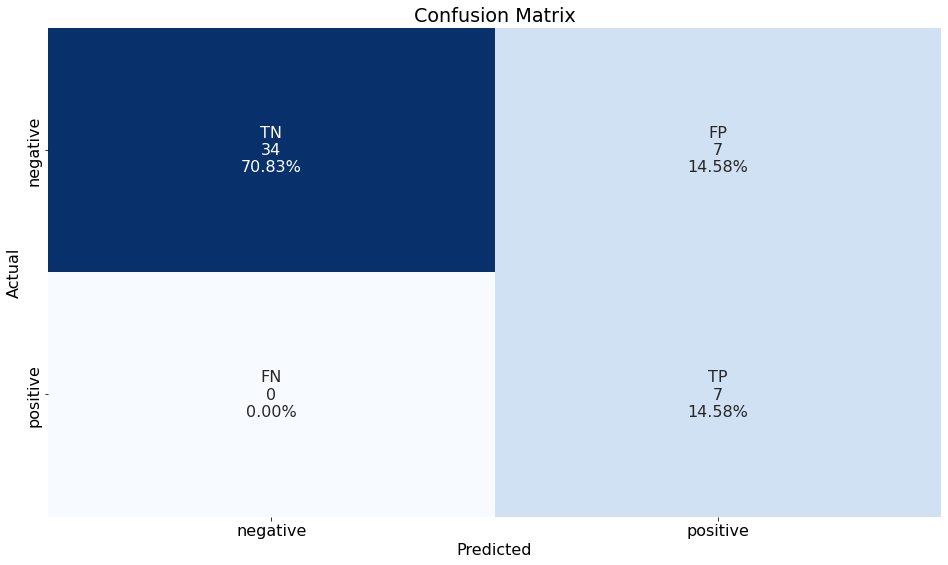

In [19]:
conf_plot(y_true = y_true, y_pred = y_pred)

## 7.3. Checking Overfitting

In [20]:
recall_score(
    average = 'macro',
    y_true = y_true,
    y_pred = y_pred
)

0.9146341463414633

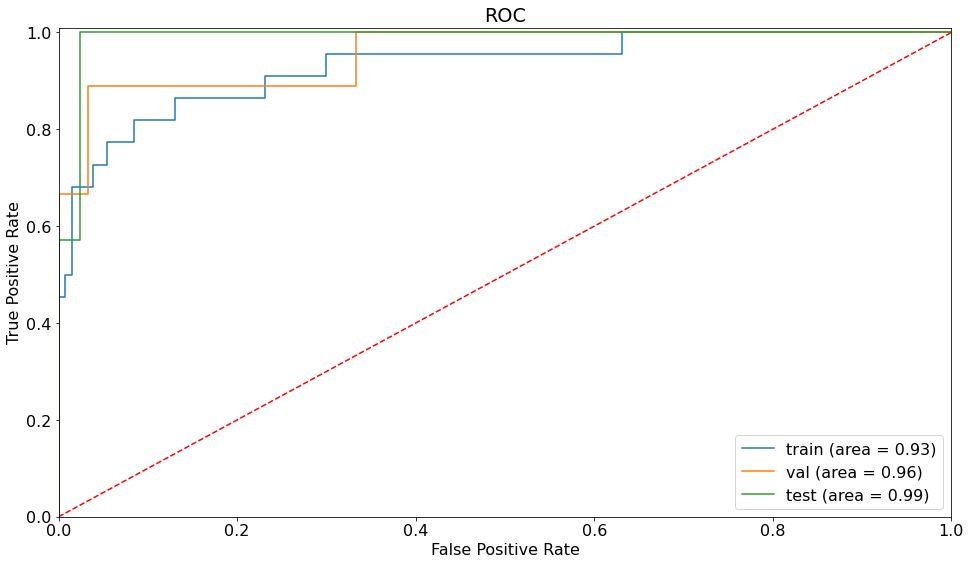

In [21]:
roc_all_split(clf = final_model, sample = chosen_row[ 'sample' ])

## 7.4. Frequency Ranking

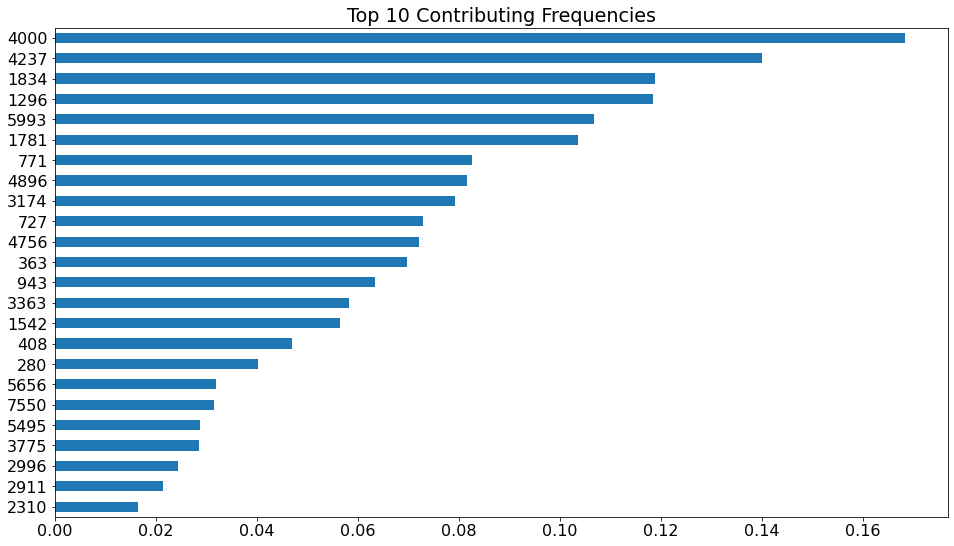

In [22]:
plot_contributions(
    pipe = final_model, 
    frequencies = chosen_row[ 'frequencies' ]
)

## 7.5. Checking Correlation

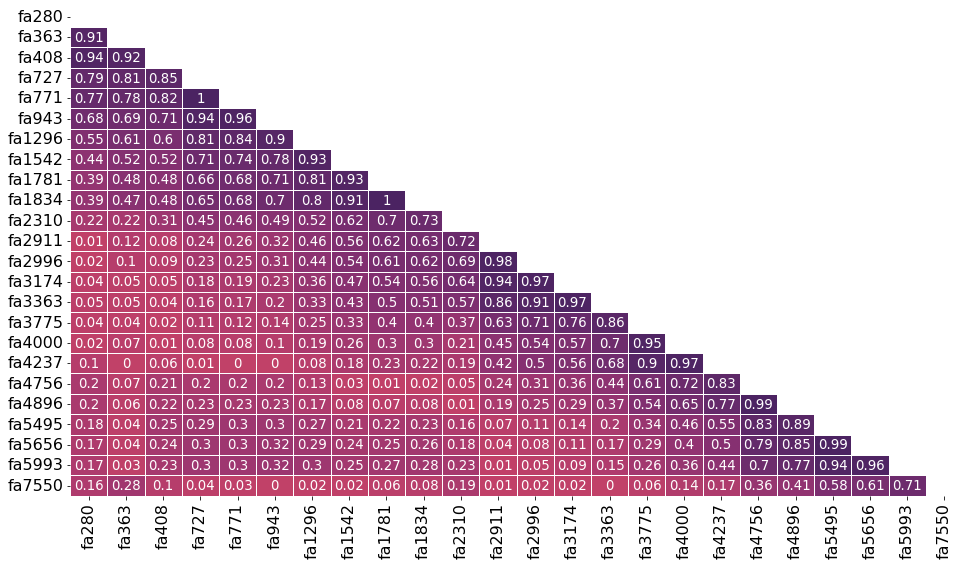

In [23]:
plot_correlation(columns = chosen_row[ 'columns' ])

## 7.6. Plotting Absorbance

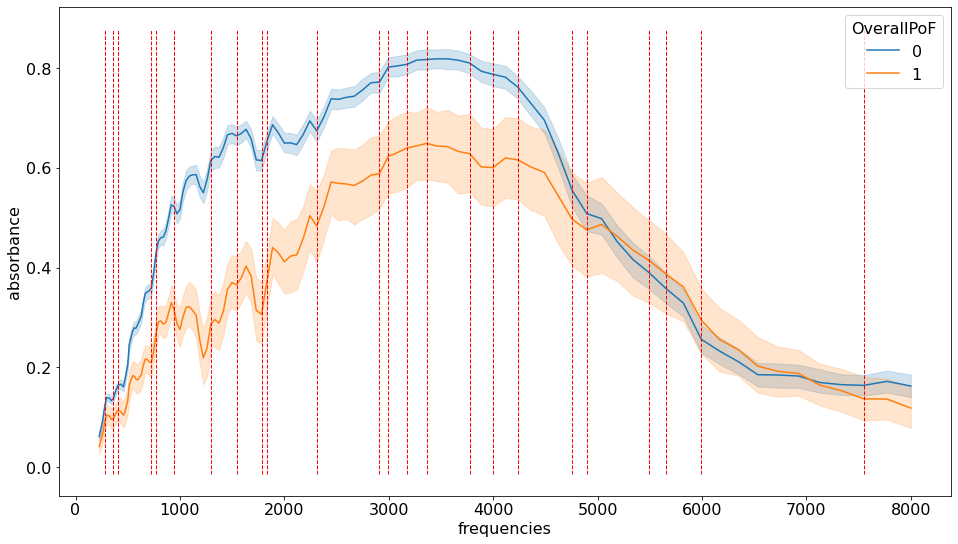

In [28]:
plot_absorbance(
    frequencies = chosen_row[ 'frequencies' ]
)